# Dictionary based approach

In [1]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import wordnet
from detoxify import Detoxify
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
dataset_path = "../data/internal/data.csv"
dataset = pd.read_csv(dataset_path)

# Define the toxicity threshold
toxicity_threshold = 0.2

### Collect toxic dict with synonyms

In [4]:
def tokenize(text):
    """ Tokenize the text into words. """
    words = re.findall(r'\w+', text.lower())
    return words

In [5]:
toxic_texts = pd.concat([
    dataset[dataset['ref_tox'] > toxicity_threshold]['reference'],
    dataset[dataset['trn_tox'] > toxicity_threshold]['translation']
], ignore_index=True)

non_toxic_texts = pd.concat([
    dataset[dataset['trn_tox'] <= toxicity_threshold]['translation'],
    dataset[dataset['ref_tox'] <= toxicity_threshold]['reference']
], ignore_index=True)

In [6]:
toxic_word_counts = Counter()
non_toxic_word_counts = Counter()

for text in toxic_texts:
    toxic_word_counts.update(tokenize(text))

for text in non_toxic_texts:
    non_toxic_word_counts.update(tokenize(text))

In [7]:
min_frequency_threshold = 5

toxic_exclusive_words = {word for word, count in toxic_word_counts.items()
                         if count > 5 * non_toxic_word_counts[word] and count >= min_frequency_threshold}

sample_toxic_dict = list(toxic_exclusive_words)[:5]
sample_toxic_dict

['sunken', 'kidnaps', 'faeces', 'narcissists', 'sled']

In [8]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
def find_non_toxic_synonyms(word):
    """ 
    Find non-toxic synonyms for a given word. 

    : param word: The word to find synonyms for.
    : return: A list of non-toxic synonyms for the given word.
    """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

In [10]:
def get_non_toxic_alternative(word, toxic_dict):
    """
    Get a non-toxic alternative for a given word.

    : param word: The word to find an alternative for.
    : param toxic_dict: A dictionary of toxic words and their non-toxic alternatives.
    : return: A non-toxic alternative for the given word.
    """
    non_toxic_synonyms = find_non_toxic_synonyms(word)
    valid_synonyms = [syn for syn in non_toxic_synonyms if syn not in toxic_dict]
    return valid_synonyms[0] if valid_synonyms else "unbelievable"

In [11]:
toxic_dict = {}

for word in toxic_exclusive_words:
    toxic_dict[word] = get_non_toxic_alternative(word, toxic_dict)

# Check a few entries in the dictionary
sample_toxic_dict_entries = list(toxic_dict.items())[:5]
sample_toxic_dict_entries

[('sunken', 'go down'),
 ('kidnaps', 'snatch'),
 ('faeces', 'fecal matter'),
 ('narcissists', 'narcissist'),
 ('sled', 'sleigh')]

### Fix sample of sentences

In [12]:
sampled_dataset = dataset.sample(n = 1000, random_state = 1)

In [13]:
def detoxify_text(text, toxic_dict):
    """
    Detoxify a given text.

    : param text: The text to detoxify.
    : param toxic_dict: A dictionary of toxic words and their non-toxic alternatives.
    : return: The detoxified text.
    """
    words = tokenize(text)
    detoxified_words = [toxic_dict.get(word, word) for word in words]
    return ' '.join(detoxified_words)

In [14]:
sampled_dataset['detoxified_reference'] = sampled_dataset['reference'].apply(lambda x: detoxify_text(x, toxic_dict))

In [15]:
sampled_dataset.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,detoxified_reference
49673,353592,"he's a boy, damn it!",He is a girl!,0.613806,0.333333,0.998986,0.000269,he s a boy blasted it
171551,393958,you'll break my arm.,You're breaking my arm.,0.906266,0.125000,0.778655,0.023060,you ll break my arm
5506,270664,"oh, shit!","Oh, man!",0.760903,0.100000,0.999319,0.000044,oh snitch
38370,230006,Carma Electra's got the best tits right now.,The Carmen Electra has vyzia the best at the m...,0.638524,0.150943,0.994833,0.000148,carma electra s got the best pap right now
36930,17313,it's gonna be shit if they get on the street.,Well be in trouble If They're out on the streets.,0.734508,0.080000,0.997544,0.000137,it s gonna be snitch if they get on the street


In [16]:
sampled_dataset.describe()

,id,similarity,lenght_diff,ref_tox,trn_tox
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,292307.053000,0.753269,0.150431,0.929916,0.008770
std,164840.553619,0.087375,0.103024,0.111861,0.011685
min,587.000000,0.600087,0.000000,0.502106,0.000037
25%,154912.500000,0.682682,0.063216,0.924496,0.000242
50%,291078.500000,0.746636,0.135135,0.979837,0.002599
75%,429570.500000,0.819678,0.222222,0.997174,0.014118
max,576879.000000,0.947137,0.400000,0.999706,0.044647


### Scores

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
def get_toxicity_score(text, toxicity_model):
    """
    Get the toxicity score for a given text.

    : param text: The text to get the toxicity score for.
    : return: The toxicity score for the given text.
    """
    results = toxicity_model.predict([text])
    return results['toxicity'][0]

In [19]:
def calculate_toxicity_reduction(original_text, detoxified_text, toxicity_model):
    """
    Calculate the toxicity reduction between an original text and its detoxified version.

    : param original_text: The original text.
    : param detoxified_text: The detoxified text.
    : param toxicity_model: The toxicity model to use.
    : return: The toxicity reduction between the two texts.
    """
    original_score = toxicity_model.predict(original_text)
    detoxified_score = toxicity_model.predict(detoxified_text)
    reduction = (original_score['toxicity'] - detoxified_score['toxicity']) / original_score['toxicity']
    return reduction

In [20]:
def calculate_semantic_similarity(original_text, detoxified_text, similarity_model):
    """
    Calculate the semantic similarity between an original text and its detoxified version.

    : param original_text: The original text.
    : param detoxified_text: The detoxified text.
    : param similarity_model: The similarity model to use.
    : return: The semantic similarity between the two texts.
    """
    original_embedding = similarity_model.encode([original_text])[0]
    detoxified_embedding = similarity_model.encode([detoxified_text])[0]
    similarity = cosine_similarity([original_embedding], [detoxified_embedding])[0][0]
    return similarity

In [21]:
def calculate_bleu_score(original_text, detoxified_text):
    """
    Calculate the BLEU score between an original text and its detoxified version.

    :param original_text: The original text.
    :param detoxified_text: The detoxified text.
    :return: The BLEU score between the two texts.
    """
    original_tokens = original_text.split()
    detoxified_tokens = detoxified_text.split()
    
    smoother = SmoothingFunction()
    
    return sentence_bleu([original_tokens], detoxified_tokens, smoothing_function=smoother.method1)

In [22]:
toxicity_model = Detoxify('original')
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

In [23]:
# Calculate the toxicity score of the detoxified references
sampled_dataset['detoxified_toxicity'] = sampled_dataset.apply(lambda row: get_toxicity_score(row['detoxified_reference'], toxicity_model), axis=1)

In [24]:
# Calculate the toxicity reduction
sampled_dataset['toxicity_reduction'] = sampled_dataset.apply(lambda row: calculate_toxicity_reduction(row['reference'], row['detoxified_reference'], toxicity_model), axis=1)

In [25]:
# Calculate the semantic similarity
sampled_dataset['semantic_similarity'] = sampled_dataset.apply(lambda row: calculate_semantic_similarity(row['reference'], row['detoxified_reference'], similarity_model), axis=1)

In [26]:
average_similarity = sampled_dataset['semantic_similarity'].mean()
average_reduction_in_toxicity = sampled_dataset['toxicity_reduction'].mean()

print(f'Average Semantic Similarity: {average_similarity}')
print(f'Average Reduction in Toxicity: {average_reduction_in_toxicity}')

Average Semantic Similarity: 0.8356700539588928
Average Reduction in Toxicity: -0.020505782216787338


In [27]:
sampled_dataset['bleu_score'] = sampled_dataset.apply(lambda row: calculate_bleu_score(row['reference'], row['detoxified_reference']),axis=1)

In [28]:
sampled_dataset['success_metric'] = sampled_dataset['bleu_score'] * (1 - sampled_dataset['detoxified_toxicity'].abs()) * sampled_dataset['semantic_similarity']

In [29]:
pd.set_option('display.float_format', lambda x: '0' if abs(x) < 1e-15 else '{:.3f}'.format(x))

In [30]:
sampled_dataset.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,detoxified_reference,detoxified_toxicity,toxicity_reduction,semantic_similarity,bleu_score,success_metric
49673,353592,"he's a boy, damn it!",He is a girl!,0.614,0.333,0.999,0.000,he s a boy blasted it,0.353,0.618,0.589,0.041,0.016
171551,393958,you'll break my arm.,You're breaking my arm.,0.906,0.125,0.779,0.023,you ll break my arm,0.700,-0.316,0.939,0.114,0.032
5506,270664,"oh, shit!","Oh, man!",0.761,0.100,0.999,0.000,oh snitch,0.554,0.435,0.272,0,0
38370,230006,Carma Electra's got the best tits right now.,The Carmen Electra has vyzia the best at the m...,0.639,0.151,0.995,0.000,carma electra s got the best pap right now,0.003,0.997,0.612,0.128,0.078
36930,17313,it's gonna be shit if they get on the street.,Well be in trouble If They're out on the streets.,0.735,0.080,0.998,0.000,it s gonna be snitch if they get on the street,0.089,0.906,0.558,0.404,0.205


### Ploting results

Differences in Toxicity, Semantic Similarity, and BLEU Score for Sampled Data:
        toxicity_difference  semantic_similarity  bleu_score  success_metric
49673                -0.646                0.589       0.041           0.016
171551               -0.078                0.939       0.114           0.032
5506                 -0.445                0.272           0               0
38370                -0.992                0.612       0.128           0.078
36930                -0.908                0.558       0.404           0.205
...                     ...                  ...         ...             ...
92292                -0.297                0.979       0.726           0.237
116934                0.012                0.896       0.310           0.045
57126                -0.189                0.888       0.786           0.140
78948                -0.878                0.978       0.809           0.757
162389               -0.928                0.365       0.054           0.0

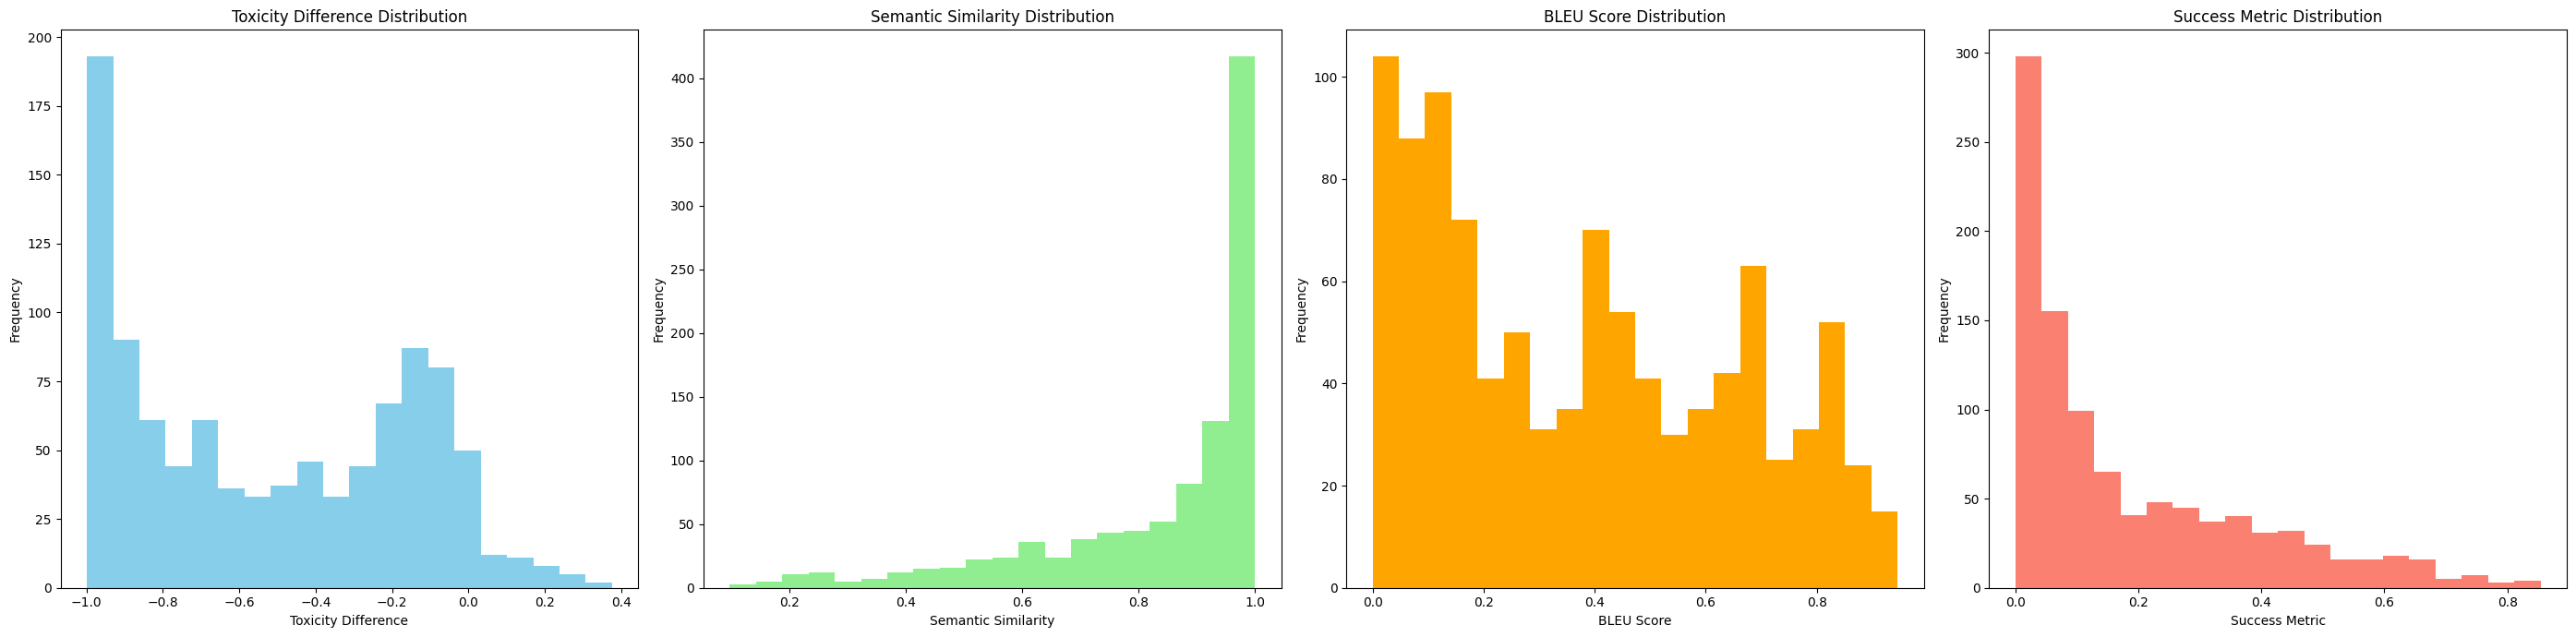

In [31]:
sampled_dataset['toxicity_difference'] = sampled_dataset['detoxified_toxicity'] - sampled_dataset['ref_tox']

print("Differences in Toxicity, Semantic Similarity, and BLEU Score for Sampled Data:")
print(sampled_dataset[['toxicity_difference', 'semantic_similarity', 'bleu_score', 'success_metric']])

fig, ax = plt.subplots(1, 4, figsize=(28, 7))

ax[0].hist(sampled_dataset['toxicity_difference'], bins=20, color='skyblue')
ax[0].set_title('Toxicity Difference Distribution')
ax[0].set_xlabel('Toxicity Difference')
ax[0].set_ylabel('Frequency')

ax[1].hist(sampled_dataset['semantic_similarity'], bins=20, color='lightgreen')
ax[1].set_title('Semantic Similarity Distribution')
ax[1].set_xlabel('Semantic Similarity')
ax[1].set_ylabel('Frequency')

ax[2].hist(sampled_dataset['bleu_score'], bins=20, color='orange')
ax[2].set_title('BLEU Score Distribution')
ax[2].set_xlabel('BLEU Score')
ax[2].set_ylabel('Frequency')

ax[3].hist(sampled_dataset['success_metric'], bins=20, color='salmon')
ax[3].set_title('Success Metric Distribution')
ax[3].set_xlabel('Success Metric')
ax[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

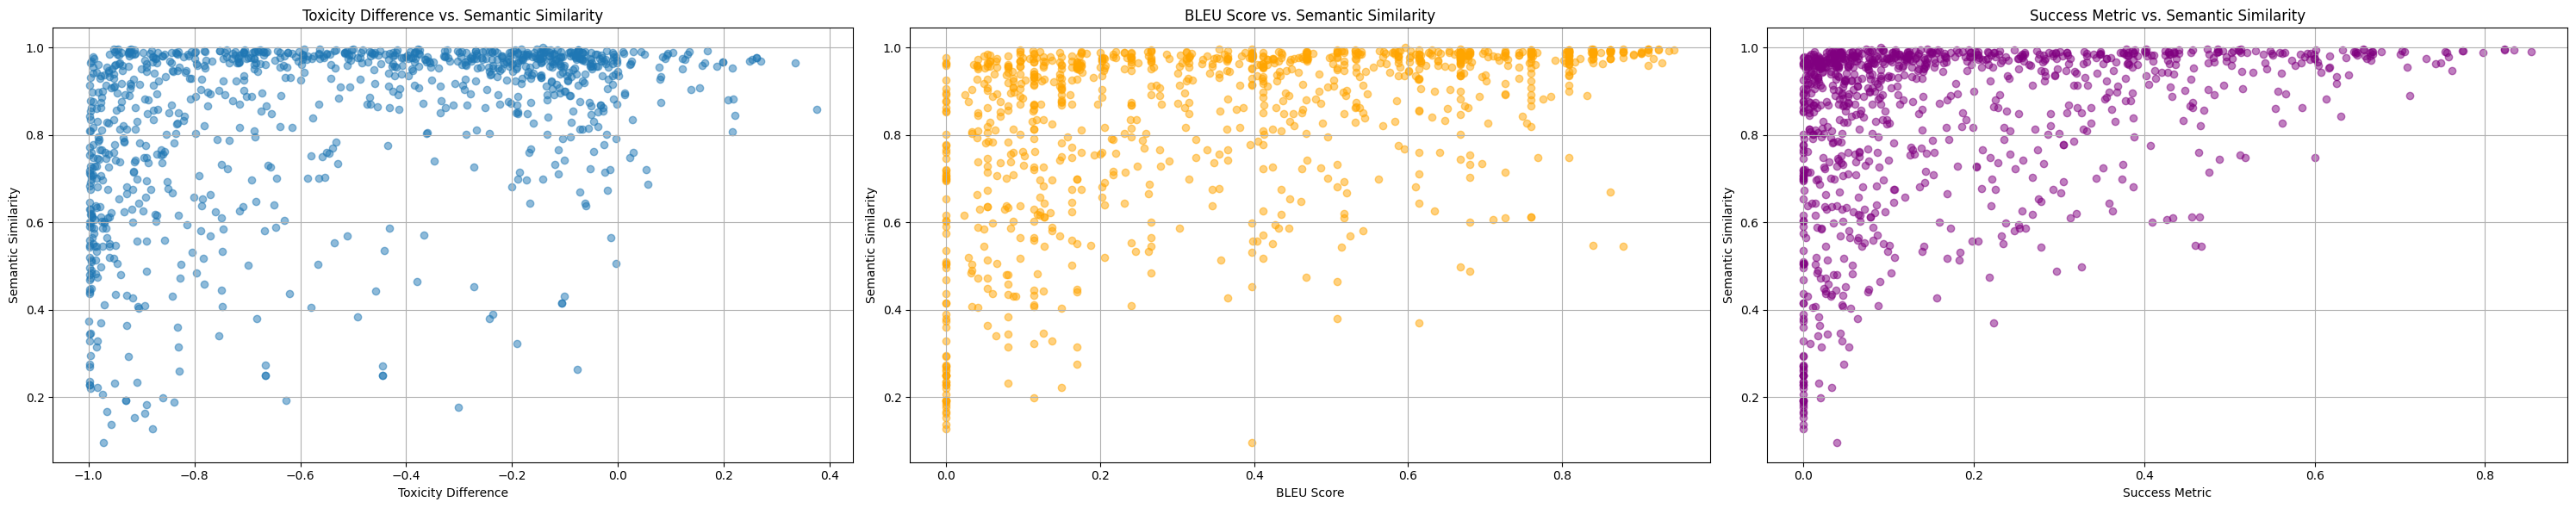

In [32]:
# Scatter plot for Toxicity Difference vs. Semantic Similarity
plt.figure(figsize=(30, 6))

plt.subplot(1, 3, 1)
plt.scatter(sampled_dataset['toxicity_difference'], sampled_dataset['semantic_similarity'], alpha=0.5)
plt.title('Toxicity Difference vs. Semantic Similarity')
plt.xlabel('Toxicity Difference')
plt.ylabel('Semantic Similarity')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(sampled_dataset['bleu_score'], sampled_dataset['semantic_similarity'], alpha=0.5, color='orange')
plt.title('BLEU Score vs. Semantic Similarity')
plt.xlabel('BLEU Score')
plt.ylabel('Semantic Similarity')
plt.grid(True)


plt.subplot(1, 3, 3)
plt.scatter(sampled_dataset['success_metric'], sampled_dataset['semantic_similarity'], alpha=0.5, color='purple')
plt.title('Success Metric vs. Semantic Similarity')
plt.xlabel('Success Metric')
plt.ylabel('Semantic Similarity')
plt.grid(True)

plt.tight_layout()
plt.show()